# Remove Background of Images

- Using grabcut [[opencv documentation](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga909c1dda50efcbeaa3ce126be862b37f), [paper](https://sci-hub.se/10.1145/1186562.1015720)]
- Manually annotate image with these [pixel values](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gad43d3e4208d3cf025d8304156b02ba38)

In [187]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [315]:
def rect_on_image(img, rect):
    return cv2.rectangle(img, rect, (0,0,0), 2)

def load_image_mask(file_path):
    mask = np.full(img.shape[:2], cv2.GC_PR_BGD, np.uint8) # GC_PR_BGD = possible background pixel
    img_mask = cv2.imread('data/giraffe_mask.png', cv2.IMREAD_GRAYSCALE)
    
    mask[img_mask == 0] = cv2.GC_PR_BGD # possible background pixel
    mask[(img_mask > 0) & (img_mask < 255)] = cv2.GC_BGD # obvious background pixel
    mask[img_mask == 255] = cv2.GC_FGD # obvious foreground pixel
    return mask

def remove_background(img, mask, rect, mode=cv2.GC_INIT_WITH_RECT, iter_count=5):
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iter_count, mode)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        
    # Smoothing of the mask
    kernel = np.ones((2, 2),np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel) # remove 'holes' in mask
    mask2 = cv2.dilate(mask2, kernel, iterations=1)
    mask2 = cv2.blur(mask2, (10, 10))
    
    img = img * mask2[:, :, np.newaxis]
    return img

CPU times: user 198 ms, sys: 7.91 ms, total: 206 ms
Wall time: 170 ms


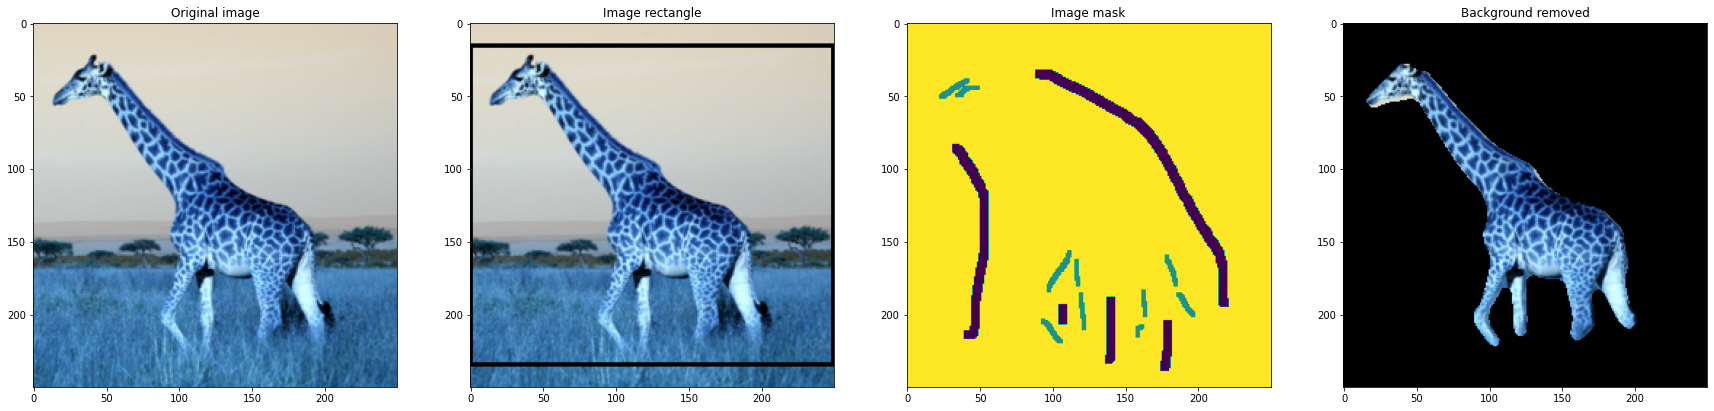

In [316]:
fig, axs = plt.subplots(1, 4, figsize=(30, 10))    

# Load image
img = cv2.imread('data/giraffe.png')
img = cv2.resize(img, (250, 250), interpolation=cv2.INTER_AREA)
axs[0].imshow(img)
axs[0].set_title('Original image')

# Construct rectangle around object
height, width = img.shape[0:2]
rect = (0, 15, width, height - 30) # (x1, y1, width, height)
axs[1].imshow(rect_on_image(img.copy(), rect))
axs[1].set_title('Image rectangle')

# Mask
# mask = np.zeros(img.shape[:2], np.uint8) # Default mask, all black
mask = load_image_mask('data/giraffe_mask.png')
axs[2].imshow(mask)
axs[2].set_title('Image mask')

%time img = remove_background(img, mask, rect, mode=cv2.GC_INIT_WITH_MASK, iter_count=5)
axs[3].imshow(rect_on_image(img, rect))
axs[3].set_title('Background removed')

plt.show()